In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xsk
import xesmf as xe
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

# # For some reason xesmf breaks with dask.distributed...
# from dask.distributed import Client
# from dask_kubernetes import KubeCluster

# cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=20, interval='2s')
# client = Client(cluster)
# client

Client Scheduler: tcp://10.32.2.8:42015 Dashboard: /user/0000-0003-0135-0814/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [3]:
df_Amon_tas = df[(df.table_id == 'Amon') & (df.variable_id == 'tas')
                & ((df.experiment_id == 'piControl') | (df.experiment_id == 'historical') | (df.experiment_id == '1pctCO2'))]
len(df_Amon_tas)

279

In [4]:
run_counts = df_Amon_tas.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id        experiment_id
BCC-CSM2-MR      1pctCO2           1
                 historical        3
                 piControl         1
BCC-ESM1         1pctCO2           1
                 historical        3
                 piControl         1
CAMS-CSM1-0      1pctCO2           2
                 historical        2
                 piControl         1
CESM2            1pctCO2           1
                 historical       11
                 piControl         1
CESM2-WACCM      1pctCO2           1
                 historical        3
                 piControl         1
CNRM-CM6-1       1pctCO2           1
                 historical       13
                 piControl         1
CNRM-ESM2-1      1pctCO2           4
                 historical        5
                 piControl         1
CanESM5          1pctCO2           6
                 historical       50
                 piControl         2
E3SM-1-0         1pctCO2           1
                 historical        5
       

In [5]:
source_ids = []
experiment_ids = ['historical', 'piControl', '1pctCO2']
for name, group in df_Amon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'NESM3',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [6]:
def load_tas_data(source_id, expt_id):
    """
    Load monthly atmospheric near-surface air temperature data for given source and expt ids
    """
    uri = df_Amon_tas[(df_Amon_tas.source_id == source_id) &
                         (df_Amon_tas.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [7]:
source_id = source_ids[0]
ds = load_tas_data(source_id, 'historical').sel(time=slice('1980', '2010')).mean(dim='time')

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 1.0)),
                     'lon': (['lon'], np.arange(0.5, 360., 1.0)),
                    }
                   )

ds_new = regrid_to_common(ds['tas'], ds_out)

Reuse existing file: bilinear_160x320_178x360_peri.nc


In [12]:
ds['tas']

<xarray.DataArray 'tas' (lat: 160, lon: 320)>
dask.array<mean_agg-aggregate, shape=(160, 320), dtype=float32, chunksize=(160, 320), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9

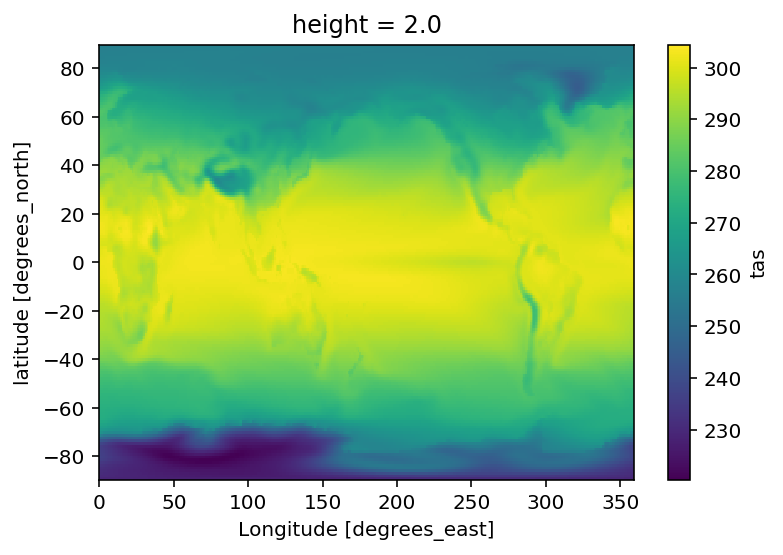

In [9]:
ds['tas'].plot()

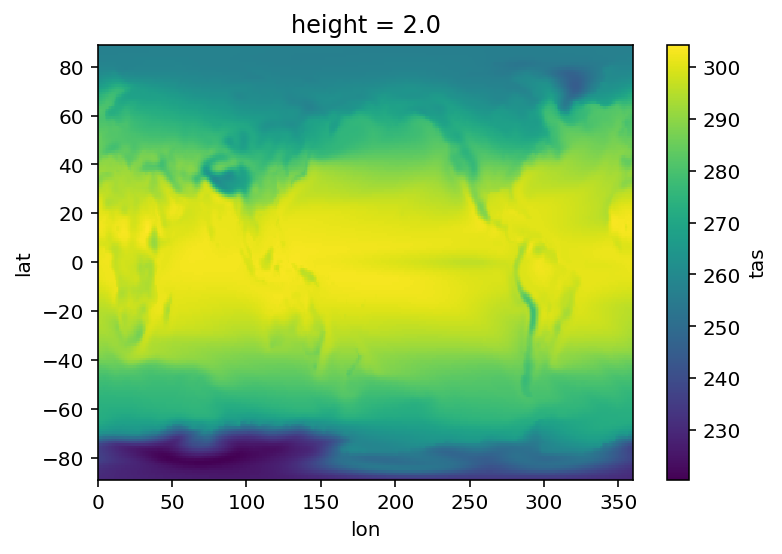

In [10]:
ds_new.plot()